# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [3]:
PATH = "./data/"

In [4]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [5]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [7]:
pd.crosstab(data.loc[:,'Sex'], data.loc[:,'Survived'], margins=True)

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


The dataset contains 314 women and 577 men. Of the 891 passengers in the training dataset, only 342 survived. Of these, 233 are women and 109 are men. For one male surviving, there are approximately 2 female survivors. It should also be noted that 74.2% of all females survived in the training dataset and only 18.9% of all males. 

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

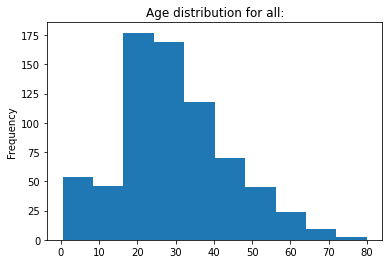

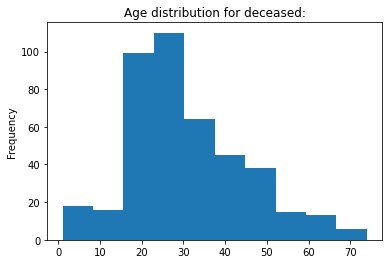

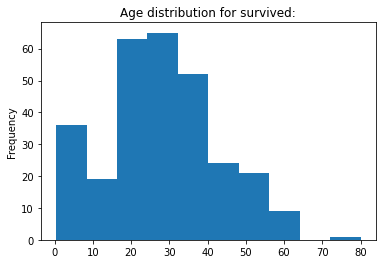

In [9]:
def drawAgeSeries(series, title=None):
    series.plot.hist()
    if title:
        plt.title(title)
    plt.show()
    
drawAgeSeries(data['Age'], 'Age distribution for all:')
drawAgeSeries(data[data['Survived'] == 0]['Age'], 'Age distribution for deceased:')
drawAgeSeries(data[data['Survived'] == 1]['Age'], 'Age distribution for survived:')

In [10]:
data.groupby('Survived', dropna=False)['Age'].agg(['median', 'mean'])

,median,mean
Survived,,
0,28.0,30.626179
1,28.0,28.343690


The average age of the surviving passengers was 28.3 years, with a median of 28 years. And the dead passengers are 30.6 years old and 28 years old, respectively. The age distribution of surviving and deceased passengers does not differ significantly between the ages of up to 5 years and from 20 to 30 years.
up to 5 years - possibly due to the fact that young children were saved in the first place
from 20 to 30 years old - with the fact that the percentage of men who survived was 18.9% of men, and women - 74.2%. Moreover, there are 1.8 times more men in the sample than women. < your thoughts >

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

Percentage of survived for each passenger class:
1    62.96
2    47.28
3    24.24

Percentage of survived for each embarkation port:
S    33.70
C    55.36
Q    38.96


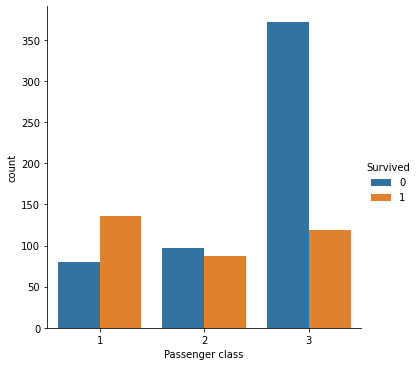

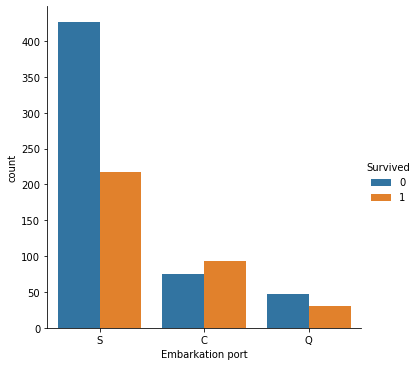

In [12]:
print(f"Percentage of survived for each passenger class:\n\
{round(data[data['Survived'] == 1]['Pclass'].value_counts() / data['Pclass'].value_counts() * 100, 2).to_string()}\n")
print(f"Percentage of survived for each embarkation port:\n\
{round(data[data['Survived'] == 1]['Embarked'].value_counts() / data['Embarked'].value_counts() * 100, 2).to_string()}")
sns.catplot(data=data, x='Pclass', hue="Survived", kind="count").set_axis_labels('Passenger class')
sns.catplot(data=data, x='Embarked', hue="Survived", kind="count").set_axis_labels('Embarkation port');

The safest class can be called the first. The death rate for passengers departing from the ports of Southampton (S) and Queenstown (Q) is higher compared to the port of Cherbourg (C). However, this connection can be explained by the fact that most of the passengers boarding at Port S bought tickets for the third class, and most of the passengers in the third class died. 

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [13]:
data.isnull().mean().sort_values(ascending=False)*100

Cabin       77.104377
Age         19.865320
Embarked     0.224467
Fare         0.000000
Ticket       0.000000
Parch        0.000000
SibSp        0.000000
Sex          0.000000
Name         0.000000
Pclass       0.000000
Survived     0.000000
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

The training set lacks values in the Cabine (77.1%), Age (19.9%), Embarked (0.22%) fields.
For now, exclude the Cabine field from consideration, since, firstly, the percentage of missing data is too large and, secondly, this field partially details the Pclass field (the deck with the designation A corresponds to the 1st class, however, with the designation E - 1 and 2 classes).
If the Age field is selected, fill in the missing values with the average for the Age field, so as not to exclude lines from the consideration.
When you select the Embarked field, delete lines with missing values, since the percentage of these lines is extremely small (0.22%). 

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [15]:
y = data['Survived']

In [16]:
scaler = StandardScaler()

features = ["Pclass", "Sex", "SibSp", "Parch"]
X_train = pd.get_dummies(data[features])
X_train_scaled = scaler.fit_transform(X_train)

KNN

In [17]:
k_neigh_quantity = np.arange(1,101)
accuracy_train_KNN, accuracy_val_KNN = [], []
for k in k_neigh_quantity:
    
    model_KNN = KNeighborsClassifier(n_neighbors = k, weights='distance')
    
    results = cross_validate(model_KNN, 
                             X_train_scaled, y, cv=5,
                             return_train_score=True,
                             scoring='accuracy')
    
    accuracy_train_KNN.append(np.mean(results['train_score']))
    accuracy_val_KNN.append(np.mean(results['test_score']))

In [18]:
best_val_index = np.array(accuracy_val_KNN).argmax() 
train_accuracy_value = accuracy_train_KNN[best_val_index]
val_accuracy_value = accuracy_val_KNN[best_val_index]

In [19]:
print(f"""\nBest k: {best_val_index+1},\ntrain_accuracy {train_accuracy_value},\nvalidation accuracy {val_accuracy_value}""")


Best k: 29,
train_accuracy 0.8215500260018596,
validation accuracy 0.7878978093026174


Logistic Regression

In [20]:
model_LR = LogisticRegression(random_state=241, max_iter=1000)

results = cross_validate(model_LR, 
                             X_train_scaled, y, cv=5,
                             return_train_score=True,
                             scoring='accuracy')

accuracy_train_LR = np.mean(results['train_score'])
accuracy_val_LR = np.mean(results['test_score'])

In [21]:
print(f"train_accuracy {accuracy_train_LR},\nvalidation accuracy {accuracy_val_LR}")

train_accuracy 0.8021884898435161,
validation accuracy 0.8002008662356411


KNN

In [22]:
k_neigh_quantity = np.arange(1,101)
accuracy_train_KNN, accuracy_val_KNN = [], []
for k in k_neigh_quantity:
    
    model_KNN = KNeighborsClassifier(n_neighbors = k, weights='distance')
    
    results = cross_validate(model_KNN, 
                             X_train_scaled, y, cv=5,
                             return_train_score=True,
                             scoring='accuracy')
    
    accuracy_train_KNN.append(np.mean(results['train_score']))
    accuracy_val_KNN.append(np.mean(results['test_score']))

In [23]:
best_val_index = np.array(accuracy_val_KNN).argmax() 
train_accuracy_value = accuracy_train_KNN[best_val_index]
val_accuracy_value = accuracy_val_KNN[best_val_index]

In [24]:
print(f"""\nBest k: {best_val_index+1},\ntrain_accuracy {train_accuracy_value},\nvalidation accuracy {val_accuracy_value}""")


Best k: 29,
train_accuracy 0.8215500260018596,
validation accuracy 0.7878978093026174


Logistic Regression

In [25]:
model_LR = LogisticRegression(random_state=241, max_iter=1000)

results = cross_validate(model_LR, 
                             X_train_scaled, y, cv=5,
                             return_train_score=True,
                             scoring='accuracy')

accuracy_train_LR = np.mean(results['train_score'])
accuracy_val_LR = np.mean(results['test_score'])

In [26]:
print(f"train_accuracy {accuracy_train_LR},\nvalidation accuracy {accuracy_val_LR}")

train_accuracy 0.8021884898435161,
validation accuracy 0.8002008662356411


On the validation data, the result of the logistic regression model is better than k nearest neighbors (0.80> 0.79). 

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

To classify the final data, we will choose a logistic regression model 

In [27]:
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

In [28]:
X_test = pd.get_dummies(test_data[features])
X_test_scaled = scaler.fit_transform(X_test)

In [29]:
model_LR.fit(X_train_scaled, y)
predictions_LR = model_LR.predict(X_test_scaled)
submission_data = pd.DataFrame({'PassengerId': X_test.index, 'Survived': predictions_LR})
submission_data.to_csv('my_submission_titanic_LR.csv', index=False)

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

The final score of the model is **0.77511**. (username: zmicag)

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [30]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [31]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [33]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [34]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [35]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [36]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [37]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

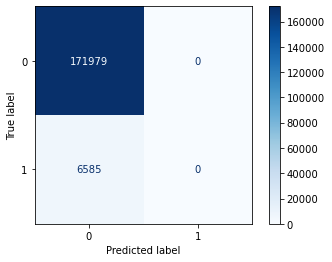

In [39]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [40]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

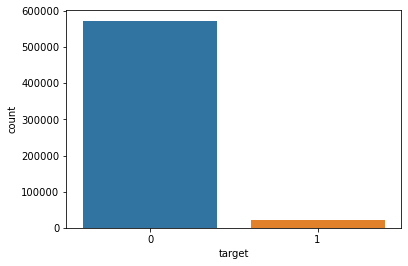

In [42]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [43]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [44]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [45]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [47]:
## your code